In [15]:
import numpy as np
import pandas as pd
import csv
from scipy.spatial import distance
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm_notebook

def read_dataset(path):
    df = pd.read_csv(path, skiprows=0)
    y = df['label'].to_numpy()
    X = df.drop('label', axis=1).to_numpy()
    return X, y

cancer_data, cancer_labels = read_dataset('cancer.csv')
spam_data, spam_labels = read_dataset('spam.csv')

**KNN part**

In [30]:
def KNN_indices(data, new_data, k=10):
    distances = np.linalg.norm(data - new_data, axis=1)
    return np.argsort(distances)[:k]

def KNN(data, new_data, labels, K=10):
    indices = KNN_indices(data, new_data, K)
    nearest_labels = labels[indices]
    res = []
    for k in range(1, K + 1):
        counts = Counter(nearest_labels[:k]).most_common(1)[0]
        res.append(counts[0])
    return np.array(res)

def calculate_looerror(data, labels, K=10):
    errors = np.zeros(K, )
    for i in tqdm_notebook(range(len(data))):
        results = KNN(np.delete(data, i, axis=0), data[i], np.delete(labels, i))
        current_errors = results != labels[i]
        errors += current_errors
    errors /= data.shape[0]
    plt.plot(range(1, K + 1), errors)
    return errors

array([0.08435852, 0.08435852, 0.07381371, 0.07381371, 0.06678383,
       0.07029877, 0.0685413 , 0.0685413 , 0.06678383, 0.0685413 ])

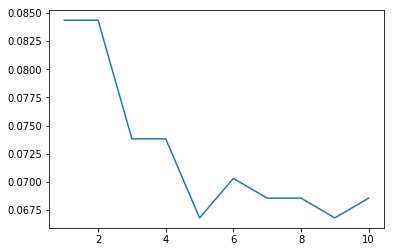

In [31]:
calculate_looerror(cancer_data, cancer_labels)

array([0.16931102, 0.16931102, 0.18561182, 0.17344056, 0.18582917,
       0.17670072, 0.19582699, 0.18235166, 0.20256466, 0.18713323])

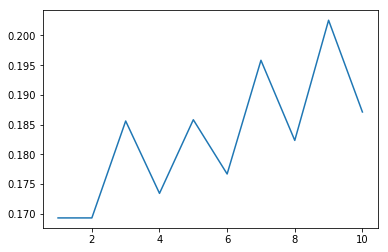

In [32]:
calculate_looerror(spam_data, spam_labels)

In [33]:
from sklearn.preprocessing import MinMaxScaler
def normalize_data(data):
    return MinMaxScaler().fit_transform(data)

array([0.08758965, 0.08758965, 0.09476201, 0.08911106, 0.0951967 ,
       0.08911106, 0.09932623, 0.09063247, 0.10193436, 0.09693545])

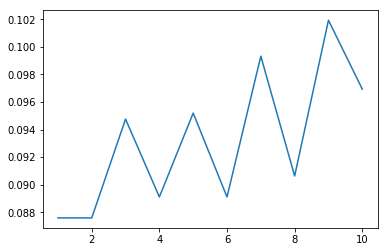

In [35]:
normalized_spam = normalize_data(spam_data.copy())
calculate_looerror(normalized_spam, spam_labels)

array([0.04745167, 0.04745167, 0.02987698, 0.02811951, 0.03339192,
       0.03163445, 0.02987698, 0.02987698, 0.02987698, 0.02636204])

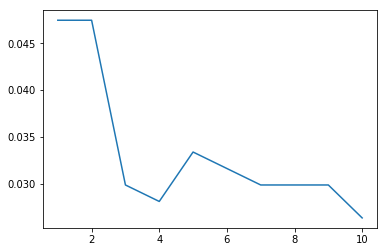

In [36]:
normalized_cancer = normalize_data(cancer_data.copy())
calculate_looerror(normalized_cancer, cancer_labels)

**Clustering part**

In [22]:
EPS = 1e-6

def kMean(data, k):
    centers = np.array([np.random.rand(data.shape[1]) for _ in range(k)])
    while True:
        ind = np.array([np.argmin(np.linalg.norm(centers - point, axis=1)) for point in data])
        # If it hapenned that there are 0 points for a cluster we will have problems. Let's fix it.
        if np.unique(ind).shape[0] != k:
            centers = np.array([np.random.rand(data.shape[1]) for _ in range(k)])
            continue
        new_centers = []
        for i in range(k):
            current_points = np.argwhere(ind == i).reshape(-1, )
            new_center = np.sum(data[current_points], axis=0) / len(current_points)
            new_centers.append(new_center)
        new_centers = np.array(new_centers)
        if np.linalg.norm(new_centers - centers) < EPS:
            return ind, centers
        centers = new_centers

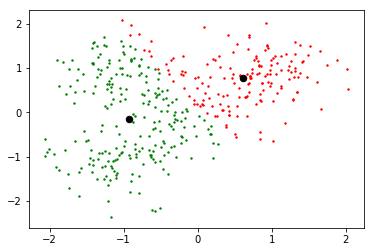

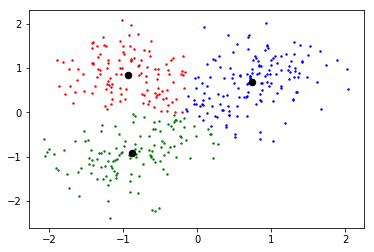

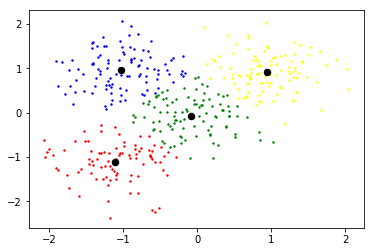

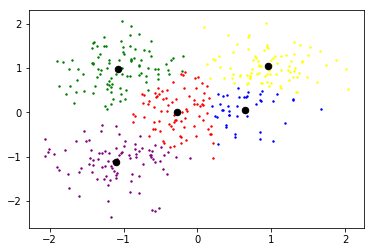

In [23]:
def read_blobs(path):
    df = pd.read_csv(path, skiprows=0)
    X = df.to_numpy()
    return X

blobs = read_blobs('blobs.csv')

def draw_clusters(clusters, centers=None):
    colors = ['red', 'green', 'blue', 'yellow', 'purple']
    plt.cla()
    for i, points in enumerate(clusters):
        plt.scatter(points[:, 0], points[:, 1], s=2, c=colors[i])
    if centers is not None:
        plt.scatter(centers[:, 0], centers[:, 1], s=42, c='black')
    plt.show()

def do_kMean(data, max_k):
    colors = ['red', 'green', 'blue', 'yellow', 'purple']
    for k in range(2, max_k + 1):
        clusters, centers = kMean(data, k)
        draw_clusters([data[np.argwhere(clusters == i).reshape(-1, )] for i in range(k)], centers)

do_kMean(blobs, 5)

Found 2 clusters


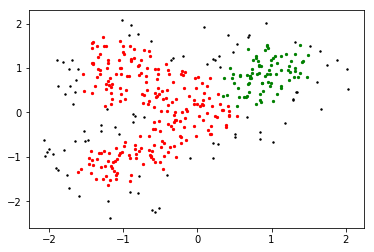

Found 3 clusters


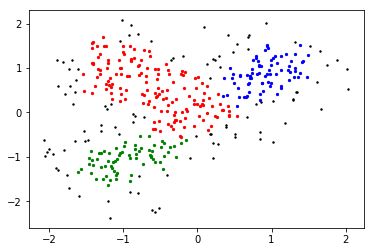

Found 4 clusters


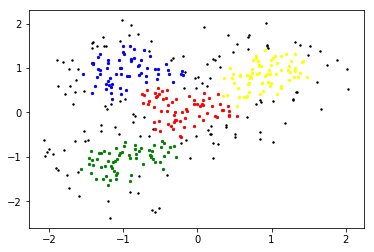

Found 5 clusters


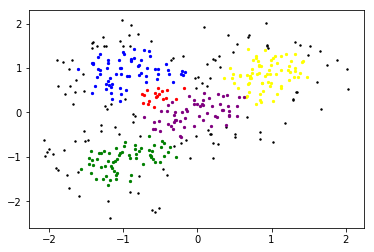

In [24]:
def dbscan(data, m, eps):
    centers = {}
    for i, row in enumerate(data):
        nearest = np.argwhere(np.linalg.norm(data - row, axis=1) <= eps).reshape(-1)
        if nearest.shape[0] > m:
            centers[i] = nearest
    
    labels = np.zeros(data.shape[0], )
    
    def dfs(point, cluster_index):
        if labels[point] != 0:
            return False
        labels[point] = cluster_index
        for nxt in centers.keys():
            if np.linalg.norm(data[point] - data[nxt]) <= eps:
                dfs(nxt, cluster_index)
        return True
    
    clusters = 0
    for center in centers:
        found = dfs(center, clusters + 1)
        if found:
            clusters += 1
            for center in np.argwhere(labels == clusters).reshape(-1):
                labels[centers[center]] = clusters
    return [data[np.argwhere(labels == i).reshape(-1)] for i in range(clusters + 1)]

def draw_dbscan_clusters(clusters):
    print('Found {} clusters'.format(len(clusters) - 1))
    colors = ['red', 'green', 'blue', 'yellow', 'purple']
    plt.cla()
    plt.scatter(clusters[0][:, 0], clusters[0][:, 1], s=2, c='black')
    for i, points in enumerate(clusters[1:]):
        plt.scatter(points[:, 0], points[:, 1], s=5, c=colors[i])
    plt.show()

draw_dbscan_clusters(dbscan(blobs, 6, 0.22))
draw_dbscan_clusters(dbscan(blobs, 7, 0.217))
draw_dbscan_clusters(dbscan(blobs, 8, 0.217))
draw_dbscan_clusters(dbscan(blobs, 10, 0.239))


Found 5 clusters


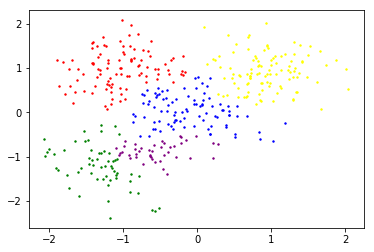

Found 4 clusters


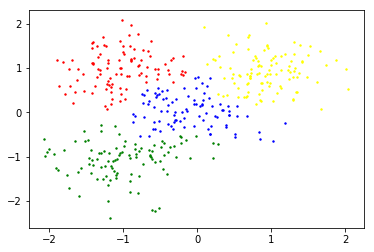

Found 3 clusters


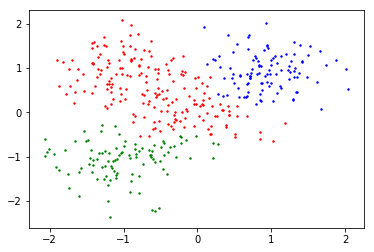

Found 2 clusters


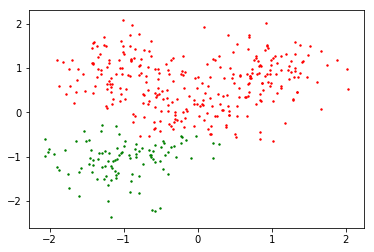

In [25]:
def algomerative_clustering(data, metric_fun, k=5):
    clusters = [[row] for row in data]
    results = []
    for _ in tqdm_notebook(range(data.shape[0] - 1)):
        best_value, best_pair = float('inf'), None
        for i in range(len(clusters)):
            for j in range(i + 1, len(clusters)):
                current_value = metric_fun(clusters[i], clusters[j])
                if current_value < best_value:
                    best_value = current_value
                    best_pair = (i, j)
        
        clusters[best_pair[0]].extend(clusters[best_pair[1]])
        clusters.pop(best_pair[1])
        best_value = float('inf')
        if len(clusters) <= k:
            results.append([np.array(cluster) for cluster in clusters])
    return results

def average_metric(x, y):
    z = np.concatenate([x, y])
    size = z.shape[0]
    return np.sum(distance.pdist(z) / (size * (size - 1) / 2))

clusters = algomerative_clustering(blobs, average_metric)
for clusterization in clusters[:-1]:
    print('Found {} clusters'.format(len(clusterization)))
    draw_clusters(clusterization)

In [514]:
def calc_purity(clusters, labels):
    max_cluster = np.max(clusters)
    value = 0
    for i in range(max_cluster + 1):
        cur_labels = labels[np.argwhere(clusters == i).reshape(-1)]
        value += Counter(cur_labels).most_common(1)[0][1]
    return value / len(clusters)

for k in [2, 3, 5, 10]:
    clusters, _ = kMean(normalized_cancer, k)
    print('Purity for {} clusters is {}'.format(k, calc_purity(clusters, cancer_labels)))

Purity for 2 clusters is 0.9279437609841827
Purity for 3 clusters is 0.9033391915641477
Purity for 5 clusters is 0.9103690685413005
Purity for 10 clusters is 0.9420035149384886


**Decesion trees**

In [222]:
def find_roc_auc(feature, labels, eps):
    tp_rate, fp_rate = [], []
    for threshold in np.arange(0, 1, eps):
        values = feature < threshold
        tp_rate.append(np.sum(np.logical_and(values == labels, labels == 1)))
        fp_rate.append(np.sum(np.logical_and(values != labels, labels == 0)))
    tp_rate = np.array(tp_rate) / np.sum(labels == 1)
    fp_rate = np.array(fp_rate) / np.sum(labels == 0)
    return np.trapz(tp_rate, x=fp_rate), fp_rate, tp_rate

def draw_best_roc_curves(data, labels):
    aucs, curves = [], []
    for feature in tqdm_notebook(range(data.shape[1])):
        auc, x, y = find_roc_auc(data[:, feature], labels, 1e-4)
        if auc < 0.5:
            x, y = y, x
            auc = 1 - auc
        aucs.append(auc)
        curves.append(np.stack((x, y), axis=-1))
    
    sorted_auc = np.argsort(np.array(aucs))
    curves = np.array(curves)
    for best in sorted_auc[-3:]:
        plt.plot(curves[best, :, 0], curves[best, :, 1])
        print(f'AUC for feature {best} is {aucs[best]}')

AUC for feature 54 is 0.7877744703682397
AUC for feature 55 is 0.8041625681254704
AUC for feature 51 is 0.8295682148930765


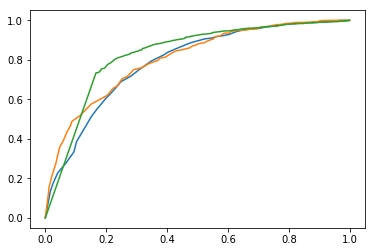

In [223]:
draw_best_roc_curves(normalized_spam, spam_labels)

AUC for feature 23 is 0.9698086781882564
AUC for feature 20 is 0.9704428941387876
AUC for feature 22 is 0.9754439511653719


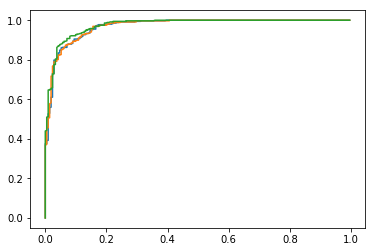

In [224]:
modified_cancer_labels = np.array([1 if l == 'M' else 0 for l in cancer_labels])
draw_best_roc_curves(normalized_cancer, modified_cancer_labels)

In [156]:
a= [3, 2,0, 1]
np.argsort(a)

array([2, 3, 1, 0])